In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
RANDOM_STATE = 1
df = pd.read_csv("../data/train.csv")

def use_lowercase(df: pd.DataFrame):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')
    return df 
df = use_lowercase(df)

In [146]:
def prepare_data(df: pd.DataFrame):
    df['cabin'] = df['cabin'].fillna('unknown')
    df['embarked'] = df['embarked'].fillna('unknown')
    df['age'] = df['age'].fillna(df['age'].mean())

    pclass_values = {
        1: 'upper',
        2: 'middle',
        3: 'lower'
    }
    df['pclass'] = df['pclass'].map(pclass_values)
    df['cabin_deck'] = df['cabin'].str[0]
    return df
    
df = prepare_data(df)



In [147]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

y_train = df_train['survived'].values
y_val = df_val['survived'].values

del df_train['survived']
del df_val['survived']

In [148]:
numerical_features = ['age', 'sibsp', 'parch',]
categorical_features = ['pclass', 'sex', 'embarked', 'cabin_deck']


In [149]:
def train(df_train, y_train, features, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, features, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [150]:
dv, model = train(df_train, y_train, categorical_features + numerical_features)
y_pred = predict(df_val, dv, categorical_features + numerical_features, model)
y_pred_train = predict(df_train, dv, categorical_features + numerical_features, model)


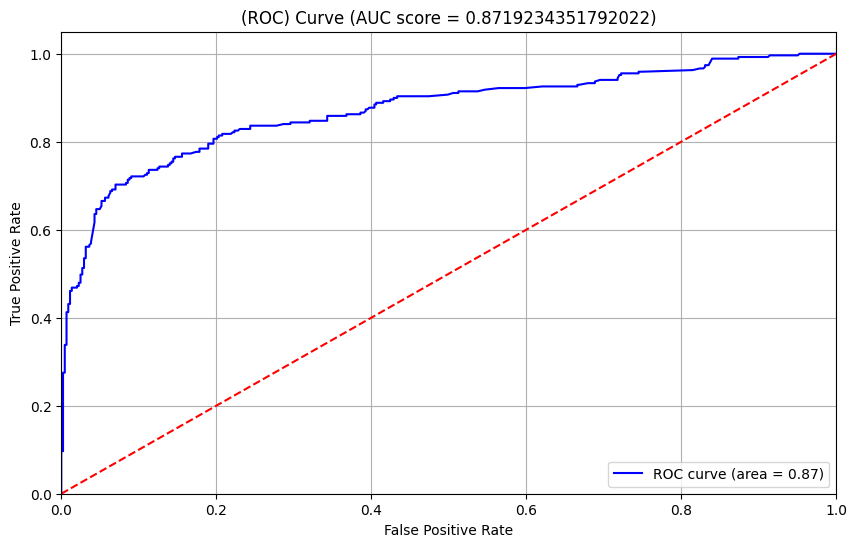

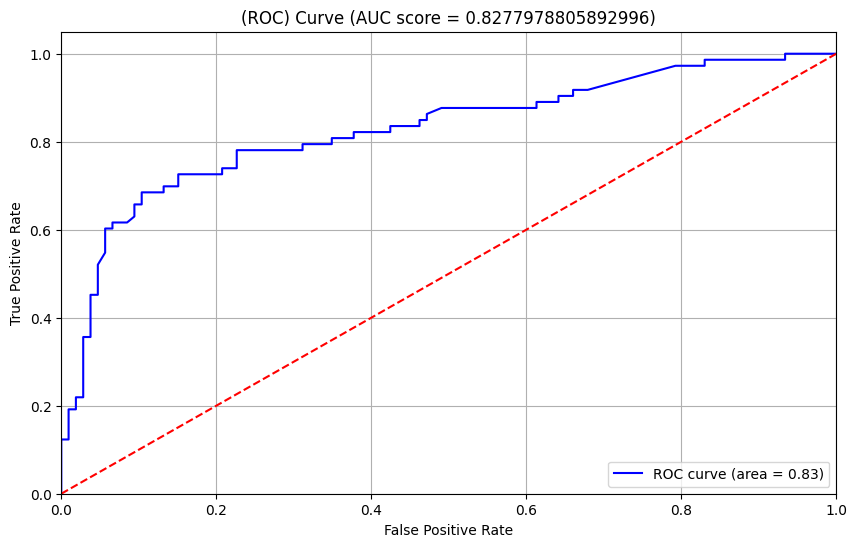

In [151]:
# plot roc curve
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true=y_true, y_score=y_score)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'(ROC) Curve (AUC score = {auc_score})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)

In [152]:
coeff_scores = list(zip(abs(model.coef_[0].round(3)), dv.get_feature_names_out()))
coeff_scores.sort(reverse=True)
coeff_scores

[(np.float64(1.321), 'sex=female'),
 (np.float64(1.313), 'sex=male'),
 (np.float64(1.127), 'cabin_deck=e'),
 (np.float64(0.981), 'pclass=lower'),
 (np.float64(0.969), 'cabin_deck=u'),
 (np.float64(0.591), 'pclass=upper'),
 (np.float64(0.424), 'embarked=s'),
 (np.float64(0.42), 'cabin_deck=d'),
 (np.float64(0.397), 'pclass=middle'),
 (np.float64(0.337), 'cabin_deck=c'),
 (np.float64(0.333), 'cabin_deck=a'),
 (np.float64(0.325), 'sibsp'),
 (np.float64(0.317), 'cabin_deck=b'),
 (np.float64(0.3), 'cabin_deck=t'),
 (np.float64(0.291), 'cabin_deck=f'),
 (np.float64(0.208), 'cabin_deck=g'),
 (np.float64(0.154), 'embarked=q'),
 (np.float64(0.15), 'embarked=unknown'),
 (np.float64(0.127), 'embarked=c'),
 (np.float64(0.04), 'age'),
 (np.float64(0.024), 'parch')]

In [153]:
selected_features = [feature for (score, feature) in coeff_scores[:8]]


In [155]:
dv, model = train(df_train, y_train, ['sex', 'cabin_deck', 'pclass'])
y_pred = predict(df_val, dv, categorical_features + numerical_features, model)
y_pred_train = predict(df_train, dv, categorical_features + numerical_features, model)

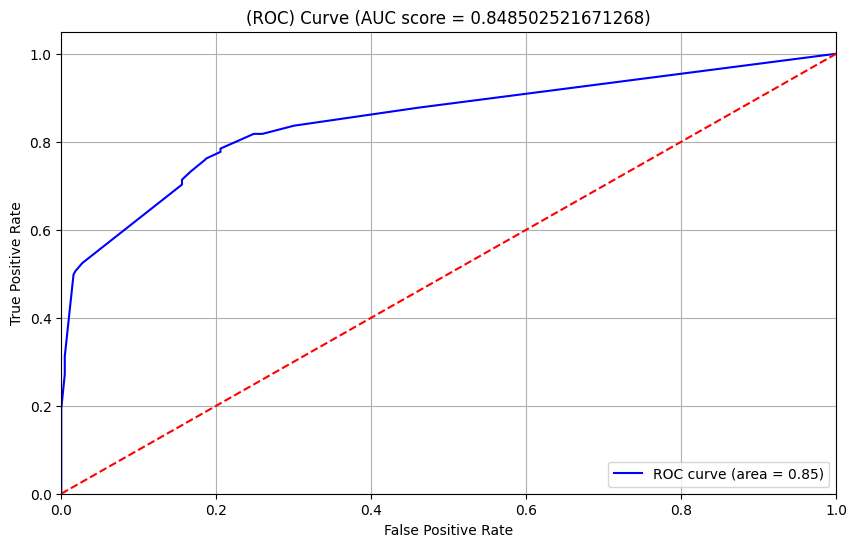

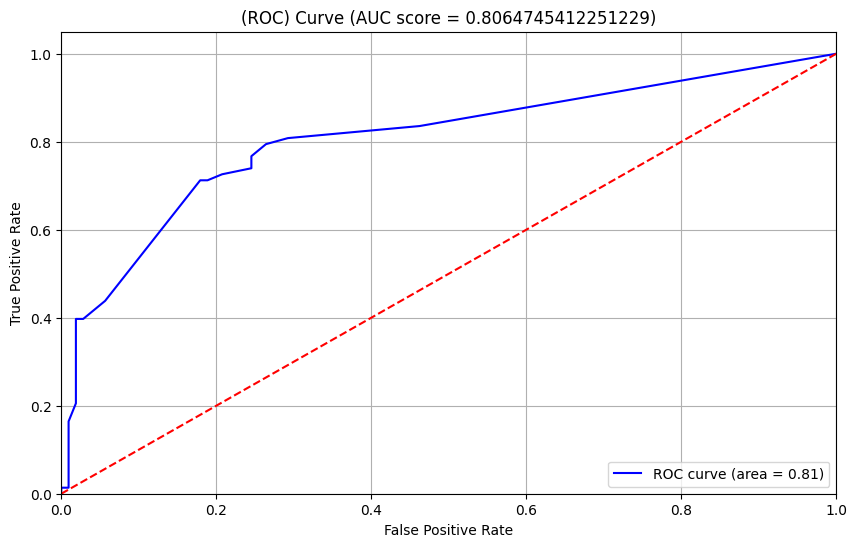

In [156]:
plot_roc_curve(y_true=y_train, y_score=y_pred_train)
plot_roc_curve(y_true=y_val, y_score=y_pred)